In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
import keras.preprocessing.image as kerasImage
import keras.backend as K
import PIL
import numpy as np
import math
import os
%matplotlib inline
import matplotlib.pyplot as plt
import inspect

Using TensorFlow backend.


In [21]:
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        #data = preprocess_input(data)
    return data

def deprocess_image(x):
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.1
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
# -- CHOOSE PARAMETERS -- #
inputSize = 224
occSize = int(input('Select the size of the occlusion mask: (1-{0})'.format(int(inputSize/4))))
occStride = int(input('Select the stride of the occlusion mask (1-10)'))

Select the size of the occlusion mask: (1-56) 15
Select the stride of the occlusion mask (1-10) 3


In [4]:
# -- LOAD MODEL -- #
model = VGG16(weights='imagenet',include_top=True)

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
# -- LOAD IMAGE -- #
selImg = input('Select an image to test: ')
fileName = './Data/images/'+selImg+'.jpg'
imgInput = load_image(fileName)

Select an image to test:  test_54


2809 (53, 53)


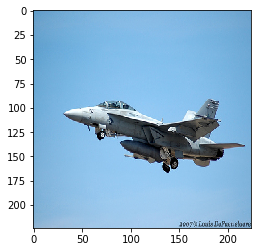

In [23]:
# -- COMPUTE PARAMETERS -- #
H,W,_ = imgInput[0].shape
outH = int(math.ceil((H-occSize)/(occStride+1)))
outW = int(math.ceil((W-occSize)/(occStride+1)))
heatMap = np.zeros((outH,outW))
print((outH*outW),(outH,outW))
plt.imshow(load_image(fileName,preprocess=False))
plt.show()

In [24]:
# -- INITIAL PREDICTION -- #
fullPred = model.predict(imgInput)
print(np.argsort(fullPred)[0][-5:][::-1])
maxClass = int(input('Select the class to explain (0-{0})'.format(model.outputs[0].get_shape()[1]-1)))
print(fullPred[0][maxClass])
# -- HEATMAP -- #
k = 1
print('------------------')
for row in range(outH):
    for col in range(outW):
        startH = row*occStride; endH = min(H,startH+occSize)
        startW = col*occStride; endW = min(W,startW+occSize)
        imgData = imgInput.copy()
        imgData[:,startH:endH,startW:endW,:] = 0
        prediction = model.predict(imgData)
        heatMap[row,col] = prediction[0][maxClass]
        if k % 50 == 0:
            print('Result: '+str(maxClass)+' ['+str(prediction[0][maxClass])+']')
            print(str(k)+' out of '+str(outH*outW))
            print('------------------')
        k += 1
# -- INVERT HEATMAP -- #
invHeatMap = 1-heatMap

[895 403 908 404 744]


Select the class to explain (0-999) 895


0.94696283
------------------
Result: 895 [0.95411795]
50 out of 2809
------------------
Result: 895 [0.9456384]
100 out of 2809
------------------
Result: 895 [0.9452594]
150 out of 2809
------------------
Result: 895 [0.945734]
200 out of 2809
------------------
Result: 895 [0.9450049]
250 out of 2809
------------------
Result: 895 [0.94407463]
300 out of 2809
------------------
Result: 895 [0.94507504]
350 out of 2809
------------------
Result: 895 [0.9480994]
400 out of 2809
------------------
Result: 895 [0.94821084]
450 out of 2809
------------------
Result: 895 [0.95103186]
500 out of 2809
------------------
Result: 895 [0.9518157]
550 out of 2809
------------------
Result: 895 [0.94686943]
600 out of 2809
------------------
Result: 895 [0.9478424]
650 out of 2809
------------------
Result: 895 [0.9453185]
700 out of 2809
------------------
Result: 895 [0.95189965]
750 out of 2809
------------------
Result: 895 [0.9494146]
800 out of 2809
------------------
Result: 895 [0.954995

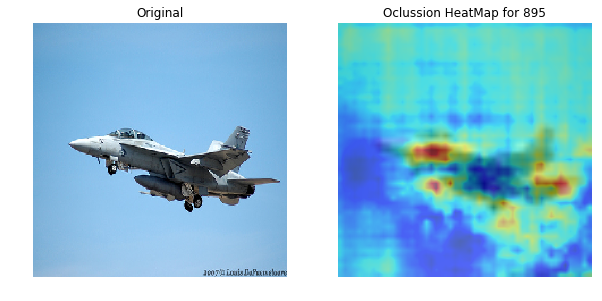

In [26]:
# -- REPRESENT RESULT -- #
if not os.path.isdir('./Results/Occlusion'):
    os.mkdir('./Results/Occlusion')
savePath = './Results/Occlusion/'+selImg+'_'+str(maxClass)+'.png'
img = load_image(fileName,preprocess=False)
imgRes = img.resize((outW, outH), PIL.Image.BILINEAR)
fig = plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.title('Original')
plt.axis('off')
plt.imshow(load_image(fileName,preprocess=False))
plt.subplot(122)
plt.title('Oclussion HeatMap for '+str(maxClass))
plt.axis('off')
plt.imshow(imgRes,interpolation='bilinear')
plt.imshow(invHeatMap,cmap='jet',interpolation='bilinear',alpha=0.5)
fig.savefig(savePath,dpi=250)